In [85]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(style="white")
import matplotlib.pyplot as plt
import matplotlib as mpl


from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split, KFold,RepeatedStratifiedKFold,RandomizedSearchCV,cross_val_score
from sklearn.metrics import(accuracy_score, roc_auc_score, f1_score, plot_confusion_matrix,precision_recall_curve, roc_curve,
                            recall_score, confusion_matrix, precision_score, classification_report)

from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier 

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC


#global variable
random_state=42

%matplotlib inline

In [18]:
df=pd.read_csv('./data/churn.csv').drop(columns=['RowNumber','Surname', 'CustomerId', 'Geography'], axis=1)
df.head(3)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,Female,42,8,159660.80,3,1,0,113931.57,1


In [19]:
df['Gender']=df['Gender'].apply(lambda x: 0 if x=='Female' else 1)

In [20]:
y = df["Exited"]
X = df.drop(["Exited"], axis = 1)

In [5]:
y.shape, X.shape

((10000,), (10000, 9))

## Data splitting

In [21]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.25, random_state=random_state)

In [22]:
X_train, X_val, y_train, y_val=train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

In [23]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)#train set scaled

In [24]:
X_val=scaler.transform(X_val)#validation set scaled

In [10]:
X_test=scaler.transform(X_test)#original dataset scaled

# Modeling 


- Logistic Classifier
- SVM classifier 
- Random Forest Classifier
- Voting Classifier

Skewed datasets are not uncommon. And they are tough to handle. Usual classification models and techniques often fail miserably when presented with such a problem. Although your model could get you to even a 99% accuracy on such cases, yet, if you are measuring yourself against a sensible metric such as the ROC Auc score, then you will face trouble getting up that leaderboard. This is because if the dataset is skewed, for example, a 10:1 ratio of Positives to Negatives occur, then by just predicting positives for every sample you see without any learning, you can get to a 90% accuracy score! So, how do we get around this problem? This post will highlight a few effective techniques you can use to do well on such tasks. The techniques range from differently sampling your data to setting some hyperparameters cleverly to using libraries that contain different versions of the usual algorithms which internally handle imbalance themselves.

In [14]:
# count examples in each class
from collections import Counter
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 3.860


In [25]:
log_clf = LogisticRegression() 
rnd_clf = RandomForestClassifier() 
svm_clf = SVC(probability=True)

In [30]:
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],voting='soft')

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svc', SVC(probability=True))],
                 voting='soft')

In [35]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(clf.__class__.__name__, accuracy_score(y_val, y_pred))

LogisticRegression 0.8037333333333333
RandomForestClassifier 0.8496
SVC 0.8533333333333334
VotingClassifier 0.8517333333333333


In [38]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    scores = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    print(clf.__class__.__name__, "Mean ROC AUC: %.5f " % (scores.mean()))

LogisticRegression Mean ROC AUC: 0.75462 
RandomForestClassifier Mean ROC AUC: 0.83297 
SVC Mean ROC AUC: 0.80324 
VotingClassifier Mean ROC AUC: 0.83335 


## Logistic Regression (tuning)

In [50]:
# define grid
param_grid= {'max_iter':[10,50,100,300], 'C':[0.001,0.01,0.5], 'solver':['newton-cg','lbfgs','liblinear','sag','saga']}
model =LogisticRegression(random_state=67)

In [51]:
# define evaluation procedure
from sklearn.model_selection import GridSearchCV
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.757279 using {'C': 0.001, 'max_iter': 10, 'solver': 'liblinear'}


In [72]:
log_clf=LogisticRegression(C=0.001, max_iter=10, solver='liblinear')
log_clf.fit(X_train, y_train)

LogisticRegression(C=0.001, max_iter=10, solver='liblinear')

## SVC (tuning)

In [52]:
# define grid
param_grid= {'max_iter':[10,50,100,-1], 'C':[0.05,0.01,1.0], 'gamma':['auto'],'kernel':['linear','poly','rbf','sigmoid']}
model =SVC(random_state=67, probability=True)

In [53]:
# define evaluation procedure
from sklearn.model_selection import GridSearchCV
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.811253 using {'C': 0.05, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1}


In [73]:
svm_clf=SVC(C= 0.05, gamma='auto', probability=True)
svm_clf.fit(X_train, y_train)

SVC(C=0.05, gamma='auto', probability=True)

### RandomForestClassifier ( tuning)

In [54]:
# define grid
param_grid= {'n_estimators':[100,300,500],'max_depth':[1,3,5,7], 'max_leaf_nodes':[5,15]}
model =RandomForestClassifier(random_state=random_state)

In [55]:
# define evaluation procedure
from sklearn.model_selection import GridSearchCV
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.843634 using {'max_depth': 7, 'max_leaf_nodes': 15, 'n_estimators': 300}


In [74]:
rnd_clf=RandomForestClassifier(max_depth=7, max_leaf_nodes=15, n_estimators=300, random_state=random_state)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_leaf_nodes=15, n_estimators=300,
                       random_state=42)

### Voting (tuning)

In [108]:
voting_clf =VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='soft')
scores = cross_val_score(voting_clf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print("MAX ROC AUC: %.5f " % (scores.max()))

MAX ROC AUC: 0.86649 


In [75]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.001, max_iter=10,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(max_depth=7,
                                                     max_leaf_nodes=15,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=0.05, gamma='auto', probability=True))],
                 voting='soft')

## ROC curve

The ROC Curve is a useful diagnostic tool for understanding the trade-off for different thresholds and the ROC AUC provides a useful number for comparing models based on their general capabilities.

If crisp class labels are required from a model under such an analysis, then an optimal threshold is required. This would be a threshold on the curve that is closest to the top-left of the plot.

In [76]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_val, log_clf.predict_proba(X_val)[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_val, rnd_clf.predict_proba(X_val)[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_val, svm_clf.predict_proba(X_val)[:,1], pos_label=1)

#roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_val))]
p_fpr, p_tpr, _ = roc_curve(y_val, random_probs, pos_label=1)

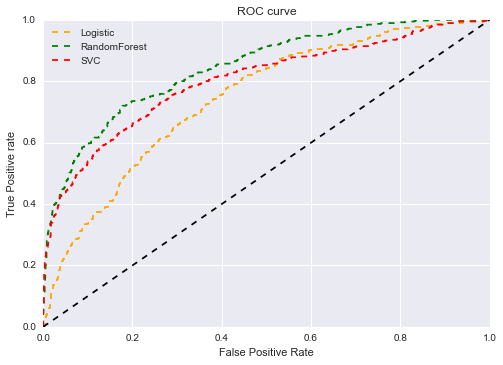

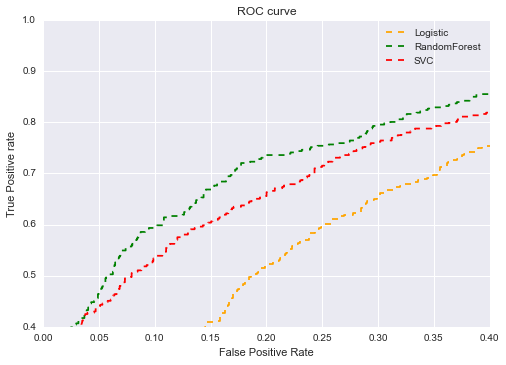

In [116]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.figure(1)
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='RandomForest')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='SVC')

plt.plot(p_fpr, p_tpr, linestyle='--', color='black')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('AllModelsROC',dpi=200)
plt.show();

plt.figure(2)
plt.xlim(0, 0.4)
plt.ylim(0.4, 1)
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='RandomForest')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='SVC')

plt.plot(p_fpr, p_tpr, linestyle='--', color='black')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
#plt.savefig('ROCzoom',dpi=200)
plt.show();

## Random Forest with a higher ROC_AUC score is a winner

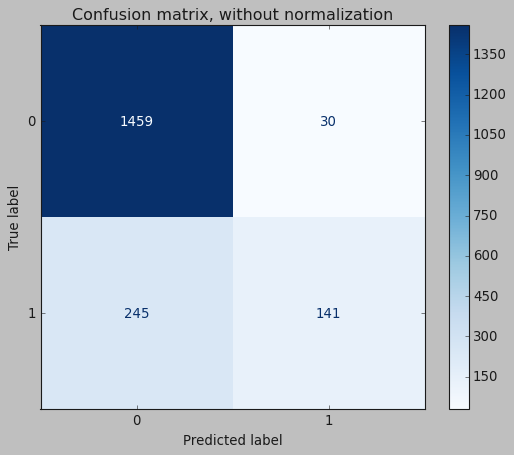

<Figure size 640x480 with 0 Axes>

In [118]:
plt.style.use('classic')
disp = plot_confusion_matrix(rnd_clf, X_val, y_val,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix, without normalization")

plt.show()
plt.savefig('ConfusionMatrixBefore',dsi=200)

In [82]:
y_hat=rnd_clf.predict(X_val)
rf_proba=rnd_clf.predict_proba(X_val)

(0.0, 1.0)

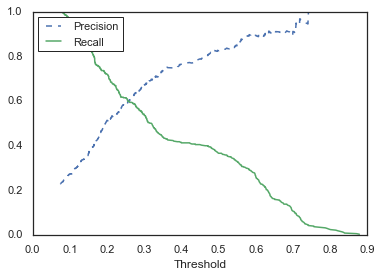

In [88]:
precisions,recalls, thresholds=precision_recall_curve(y_val, rf_proba[:,1])
plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left") 
plt.ylim([0, 1])

## Threshold setting

There are many ways we could locate the threshold with the optimal balance between false positive and true positive rates.

Firstly, the true positive rate is called the Sensitivity. The inverse of the false-positive rate is called the Specificity.

- Sensitivity = TruePositive / (TruePositive + FalseNegative)
- Specificity = TrueNegative / (FalsePositive + TrueNegative)
- Where:
- Sensitivity = True Positive Rate 
- Specificity = 1 – False Positive Rate

In [101]:
threshold=0.5
y_val_60=(rf_proba[:,1] > threshold)

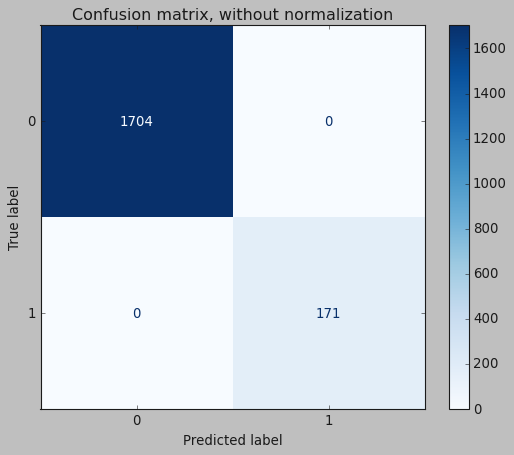

In [119]:
plt.style.use('classic')
disp = plot_confusion_matrix(rnd_clf, X_val, y_val_60, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix, without normalization")

plt.show()

## Test set

In [112]:
y_hat=rnd_clf.predict(X_test)
rf_proba=rnd_clf.predict_proba(X_test)

In [114]:
threshold=0.5
y_test_60=(rf_proba[:,1] > threshold)

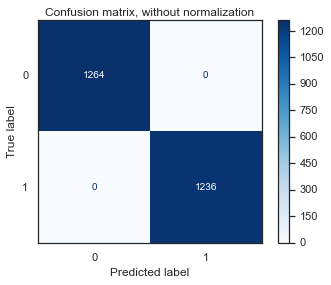

In [115]:
disp = plot_confusion_matrix(rnd_clf, X_test, y_test_60,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix, without normalization")

plt.show()